# Kacheln von Bildern mit Überlappung
Bei der Verarbeitung von Bildern in Kacheln können wir Artefakte an den Rändern der Kacheln im resultierenden Bild beobachten. Eine Strategie, um diese Artefakte zu verhindern, ist die Verarbeitung von Kacheln mit einer gewissen Überlappung. [dask](https://docs.dask.org/en/stable/) unterstützt dies ebenfalls. Zu Demonstrationszwecken verwenden wir wieder `imshow`, um die resultierenden Bilder anzuzeigen. Bei großen Datenmengen würde die Funktion `imshow` nicht funktionieren.

In [1]:
import dask
import dask.array as da
from skimage.filters import gaussian
from skimage.data import cells3d
from pyclesperanto_prototype import imshow

Ähnlich wie im Beispiel der letzten Lektion definieren wir eine Prozedur, die einen Gauß-Weichzeichner auf ein Bild anwendet und die Größe des Bildes ausgibt, nur damit wir es wissen:

In [2]:
def procedure(image):
    print("proceduring", image.shape)
    return gaussian(image, sigma=5)

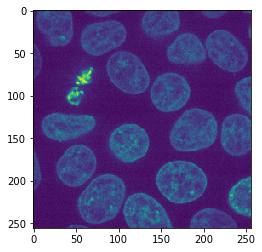

In [3]:
image = cells3d()[30,1]
imshow(image)

Nachdem wir das Bild geladen haben, kacheln wir es wie gewohnt.

In [4]:
tiles = da.from_array(image, chunks=(128, 128))
tiles

dask.array<array, shape=(256, 256), dtype=uint16, chunksize=(128, 128), chunktype=numpy.ndarray>

Als Nächstes teilen wir dask mit, was mit unseren Kacheln geschehen soll: Wir möchten die Funktion `procedure` auf die Kacheln mit einer [definierten Überlappung](https://docs.dask.org/en/stable/generated/dask.array.map_overlap.html#dask.array.map_overlap) anwenden.

In [5]:
overlap_width = 1
tile_map = da.map_overlap(procedure, tiles, depth=overlap_width)

proceduring (0, 0)
proceduring (1, 1)


/Users/haase/opt/anaconda3/envs/bio_39/lib/python3.9/site-packages/dask/array/overlap.py:642: FutureWarning: Default 'boundary' argument value will change from 'reflect' to 'none' in future versions from 2022.03.0 onwards. Use 'boundary="none"' to opt into the future behavior now or set 'boundary="reflect"' to maintain the current behavior going forward.
  warnings.warn(


Die Funktion wurde zweimal mit sehr kleinen Bildern (0x0 und 1x1 Pixel) ausgeführt, um zu prüfen, ob sie funktioniert. Als Nächstes berechnen wir tatsächlich das Ergebnis.

In [6]:
result = tile_map.compute() # Warnung: Dies lädt alle Bilddaten in den Speicher

proceduringproceduring (130, 130)
proceduring (130, 130)
 (130, 130)
proceduring (130, 130)


Anhand der ausgegebenen Bildgröße können wir sehen, dass die verarbeitete Bildgröße 2 Pixel größer ist als die Kachelgröße. Das ist die Überlappung von 1 Pixel in alle Richtungen. 

## Minimierung von Randeffekten
Als Nächstes werden wir das Ergebnis der Verarbeitung des gesamten Bildes mit dem in Kacheln verarbeiteten Bild mit verschiedenen Überlappungen vergleichen. Dies gibt uns die Möglichkeit, die minimal notwendige Überlappungsbreite zur Eliminierung von Randeffekten zu ermitteln. Zunächst berechnen wir das Ergebnis für das gesamte Bild.

In [7]:
untiled_result = procedure(image)

proceduring (256, 256)


Dann führen wir eine Schleife mit verschiedenen `border_width`s aus.

Overlap width 0
proceduring (0, 0)
proceduring (1, 1)
proceduringproceduring (128, 128)
proceduring (128, 128) (128, 128)

proceduring (128, 128)


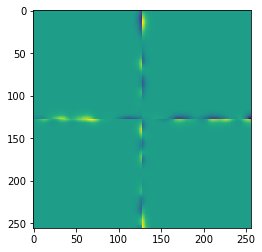

sum difference 1.528818863147824
-----------------------------------
Overlap width 5
proceduring (0, 0)
proceduring (1, 1)
proceduring (138, 138)
proceduring (138, 138)
proceduring (138, 138)
proceduring (138, 138)


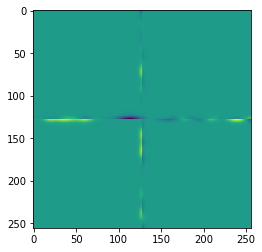

sum difference 2.098167990865754
-----------------------------------
Overlap width 10
proceduring (0, 0)
proceduring (1, 1)
proceduringproceduring (148, 148)
 (148, 148)
proceduring (148, 148)
proceduring (148, 148)


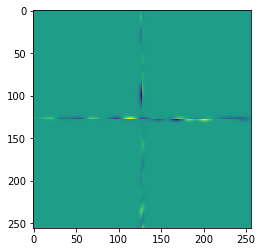

sum difference -0.18132395183423158
-----------------------------------
Overlap width 15
proceduring (0, 0)
proceduring (1, 1)
proceduring (158, 158)
proceduring (158, 158)
proceduring (158, 158)
proceduring (158, 158)


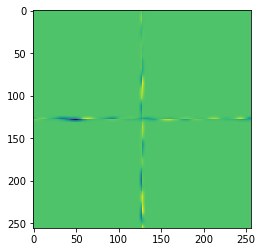

sum difference -0.005761703866654207
-----------------------------------
Overlap width 20
proceduring (0, 0)
proceduring (1, 1)
proceduring (168, 168)
proceduring (168, 168)
proceduring (168, 168)
proceduring (168, 168)


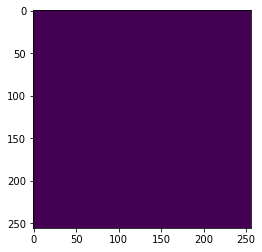

sum difference 0.0
-----------------------------------


In [8]:
for overlap_width in range(0, 25, 5):
    print("Overlap width", overlap_width)
    tile_map = da.map_overlap(procedure, tiles, depth=overlap_width, boundary='nearest')
    result = tile_map.compute()
    difference = result - untiled_result
    imshow(difference)
    print("sum difference", difference.sum())
    print("-----------------------------------")

Wie Sie sehen können, benötigen wir zur vollständigen Eliminierung des Randeffekts eine Überlappung von 25 Pixeln. Dies hängt offensichtlich mit der angewendeten `procedure` zusammen. In unserem Fall wurde der in `procedure` verwendete Gauß-Weichzeichner mit `sigma=5` konfiguriert. Als Faustregel können wir sagen, dass im Fall eines Gauß-Weichzeichners die Randbreite mindestens das Vierfache des konfigurierten Sigma betragen muss. Bei komplizierteren Algorithmen gibt es jedoch keine solchen Regeln. Im Allgemeinen wird empfohlen, die gekachelte Bildverarbeitung an kleinen Bildern zu testen, wie hier gezeigt, und herauszufinden, ob Artefakte auftreten und welche Fehler sie in einem längeren Bildverarbeitungsworkflow verursachen können.